In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths per i dati
train_path_ko = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train/KO'
train_path_tsla = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train/TSLA'

def load_images_from_folder(folder):
    images = []
    labels = []
    label = 1 if "TSLA" in folder else 0  # 1 per TSLA, 0 per KO
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('RGB')
        img = img.resize((224, 224))  # Resizing per ResNet50
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Caricamento immagini e etichette
ko_images, ko_labels = load_images_from_folder(train_path_ko)
tsla_images, tsla_labels = load_images_from_folder(train_path_tsla)

# Combina i dati e suddividi per training e validation
X = np.concatenate((ko_images, tsla_images), axis=0)
y = np.concatenate((ko_labels, tsla_labels), axis=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizzazione dei pixel tra 0 e 1
X_train = X_train / 255.0
X_val = X_val / 255.0


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Carica il modello ResNet50 pre-addestrato su ImageNet senza i livelli finali
base_model = ResNet50(weights='/Users/roberto/Downloads/resnet50_weights_tf_dim_ordering_tf_kernels_notop (2).h5', 
                      include_top=False, input_shape=(224, 224, 3))

# Congela i pesi del modello di base
for layer in base_model.layers:
    layer.trainable = False

# Aggiungi livelli fully connected personalizzati
x = base_model.output
x = Flatten()(x)  # Appiattisci l'output della rete convoluzionale
x = Dense(512, activation='relu')(x)  # Aggiungi un livello denso
predictions = Dense(2, activation='softmax')(x)  # Due classi: KO e TSLA

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Compila il modello
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Stampa il sommario del modello
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 74,969,474 (285.99 MB)

 Trainable params: 51,381,762 (196.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

addestramento del modello ::

In [3]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 998ms/step - accuracy: 0.4865 - loss: 8.1473 - val_accuracy: 0.5145 - val_loss: 0.6964
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 955ms/step - accuracy: 0.5086 - loss: 0.7362 - val_accuracy: 0.5145 - val_loss: 0.7321
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 881ms/step - accuracy: 0.5122 - loss: 0.7358 - val_accuracy: 0.4855 - val_loss: 0.9541
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 885ms/step - accuracy: 0.5150 - loss: 0.8287 - val_accuracy: 0.5145 - val_loss: 0.7928
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 873ms/step - accuracy: 0.5324 - loss: 0.7474 - val_accuracy: 0.4881 - val_loss: 0.7631
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 880ms/step - accuracy: 0.5388 - loss: 0.7615 - val_accuracy: 0.4855 - val_loss: 0.8620
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 883ms/step - accuracy: 0.5415 - loss: 0.7235 - val_accuracy: 0.4855 - val_loss: 0.7993
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 879ms/step - accuracy: 0.5125 - loss: 0.7587 - val_accu

Valutazione e visualizzazione delle prestazioni

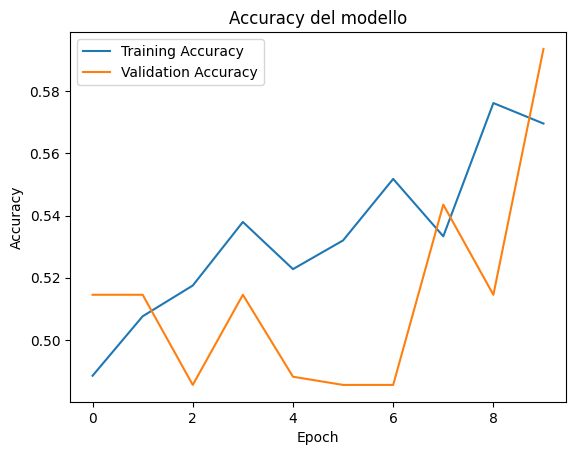

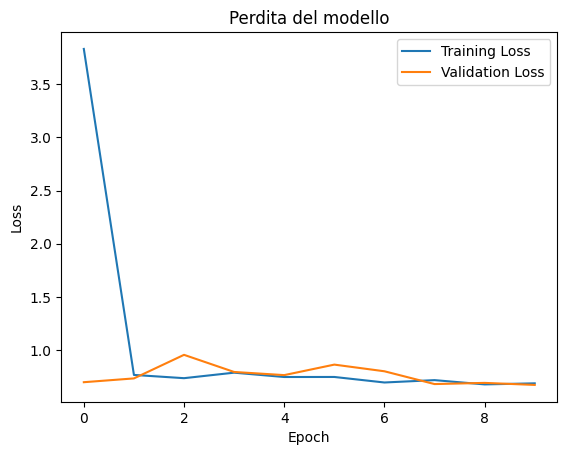

In [4]:
import matplotlib.pyplot as plt

# Plot della precisione
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy del modello')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot della perdita
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perdita del modello')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test e valutazione finale

In [7]:
# Caricamento dei dati di test per KO e TSLA
test_ko_images, test_ko_labels = load_images_from_folder('/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test/KO')
test_tsla_images, test_tsla_labels = load_images_from_folder('/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test/TSLA')

X_test = np.concatenate((test_ko_images, test_tsla_images), axis=0) / 255.0
y_test = np.concatenate((test_ko_labels, test_tsla_labels), axis=0)

# Valutazione del modello
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

3/3 - 2s - 598ms/step - accuracy: 0.6585 - loss: 0.6278

Test accuracy: 0.6585366129875183
